#Улучшенная версия Sentence Transformer с различными стратегиями агрегации

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 14.4 MB/s eta 0:00:00


In [ ]:
from utils import calc_metrics

In [ ]:
import sys
import os
import warnings
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
import optuna
from sklearn.metrics import accuracy_score, f1_score
import torch.nn as nn
import torch.nn.functional as F

warnings.filterwarnings('ignore')

#X = pd.read_csv("x.csv", index_col="date")
#y = pd.read_csv("y.csv", index_col="date").iloc[:, 0]
X = pd.read_csv("../data/x.csv", index_col="date")
y = pd.read_csv("../data/y.csv", index_col="date").iloc[:, 0]

class ImprovedSentenceTransformer:

    def __init__(self, model_name='sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)

    def mean_pooling(self, model_output, attention_mask):
        #Стандартный mean pooling
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def max_pooling(self, model_output, attention_mask):
        #Max pooling для выделения наиболее важных признаков
        token_embeddings = model_output[0]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        token_embeddings = token_embeddings * input_mask_expanded
        return torch.max(token_embeddings, dim=1)[0]

    def weighted_pooling(self, model_output, attention_mask):
        #Взвешенный pooling с убывающими весами по позиции
        token_embeddings = model_output[0]
        seq_len = token_embeddings.size(1)

        # Создаем веса: больший вес для начала текста
        weights = torch.exp(-0.1 * torch.arange(seq_len, dtype=torch.float32))
        weights = weights.to(self.device).unsqueeze(0).unsqueeze(-1)

        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        weighted_embeddings = token_embeddings * input_mask_expanded * weights

        return torch.sum(weighted_embeddings, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def attention_pooling(self, model_output, attention_mask):
        #Attention-based pooling
        token_embeddings = model_output[0]
        # Простой attention механизм
        attention_weights = torch.tanh(token_embeddings).mean(dim=-1)
        attention_weights = F.softmax(attention_weights, dim=1)
        attention_weights = attention_weights.unsqueeze(-1)
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        weighted_embeddings = token_embeddings * attention_weights * input_mask_expanded
        return torch.sum(weighted_embeddings, 1)

    def hierarchical_chunking(self, encoded_input, window_size=512, overlap=50, pad_token_id=1):
        #Улучшенная стратегия разбиения с иерархической структурой
        input_ids = encoded_input['input_ids']
        n = input_ids.size(1)
        # Если текст короткий, возвращаем как есть
        if n <= window_size:
            return encoded_input
        step = window_size - overlap
        num_chunks = (n + step - 1) // step
        chunks = torch.full((num_chunks, window_size), pad_token_id, dtype=torch.long)
        token_type_ids = torch.full((num_chunks, window_size), 0, dtype=torch.long)
        attention_mask = torch.full((num_chunks, window_size), 0, dtype=torch.long)

        chunk_positions = []
        for i in range(num_chunks):
            start = i * step
            end = start + window_size
            chunk_data = input_ids[:, start:end]
            chunk_length = chunk_data.size(1)

            chunks[i, :chunk_length] = chunk_data
            attention_mask[i, :chunk_length] = 1

            chunk_positions.append(i / max(1, num_chunks - 1))

        return {
            'input_ids': chunks,
            'token_type_ids': token_type_ids,
            'attention_mask': attention_mask,
            'chunk_positions': torch.tensor(chunk_positions, dtype=torch.float32)
        }

    def smart_chunk_aggregation(self, chunk_embeddings, chunk_positions, strategy='weighted_importance'):
        #Умная агрегация чанков с учетом их важности. Всегда возвращает тензор одинакового размера
        base_dim = chunk_embeddings.size(-1)
        if strategy == 'mean':
            return chunk_embeddings.mean(0)
        elif strategy == 'max':
            return torch.max(chunk_embeddings, dim=0)[0]
        elif strategy == 'weighted_position':
            # Больший вес для начальных чанков
            weights = torch.exp(-2 * chunk_positions).to(self.device)
            weights = weights / weights.sum()
            return torch.sum(chunk_embeddings * weights.unsqueeze(-1), dim=0)

        elif strategy == 'attention_weighted':
            # Attention-based веса для чанков
            chunk_importance = torch.norm(chunk_embeddings, dim=1)
            weights = F.softmax(chunk_importance, dim=0)
            return torch.sum(chunk_embeddings * weights.unsqueeze(-1), dim=0)

        elif strategy == 'concatenate_top_k':
            # Берем top-k наиболее важных чанков, но возвращаем базовую размерность
            k = min(3, len(chunk_embeddings))
            chunk_importance = torch.norm(chunk_embeddings, dim=1)
            top_k_indices = torch.topk(chunk_importance, k)[1]
            selected_chunks = chunk_embeddings[top_k_indices]
            return selected_chunks.mean(0)

        else:# Комбинированная стратегия - возвращаем только взвешенное среднее
            weights = torch.exp(-chunk_positions).to(self.device)
            weights = weights / weights.sum()
            return torch.sum(chunk_embeddings * weights.unsqueeze(-1), dim=0)

    def extract_embeddings(self, texts, pooling_strategy='mean', chunk_aggregation='weighted_position'):
        #Извлечение эмбеддингов с различными стратегиями
        embeddings = []
        expected_dim = None
        for text in tqdm(texts, desc="Extracting embeddings"):
            enc_input = self.tokenizer(text, truncation=False, return_tensors='pt')
            for key in enc_input:
                enc_input[key] = enc_input[key].to(self.device)
            if enc_input['input_ids'].size(1) > 512:
                chunked_input = self.hierarchical_chunking(enc_input)
                chunk_embeddings = []
                with torch.no_grad():
                    for i in range(chunked_input['input_ids'].size(0)):
                        chunk_data = {
                            'input_ids': chunked_input['input_ids'][i:i+1],
                            'attention_mask': chunked_input['attention_mask'][i:i+1],
                            'token_type_ids': chunked_input['token_type_ids'][i:i+1]
                        }

                        output = self.model(**chunk_data)

                        if pooling_strategy == 'mean':
                            embedding = self.mean_pooling(output, chunk_data['attention_mask'])
                        elif pooling_strategy == 'max':
                            embedding = self.max_pooling(output, chunk_data['attention_mask'])
                        elif pooling_strategy == 'weighted':
                            embedding = self.weighted_pooling(output, chunk_data['attention_mask'])
                        elif pooling_strategy == 'attention':
                            embedding = self.attention_pooling(output, chunk_data['attention_mask'])
                        else:
                            embedding = self.mean_pooling(output, chunk_data['attention_mask'])
                        chunk_embeddings.append(embedding.squeeze(0))
                chunk_embeddings = torch.stack(chunk_embeddings)

                # Агрегируем чанки
                final_embedding = self.smart_chunk_aggregation(
                    chunk_embeddings,
                    chunked_input['chunk_positions'],
                    chunk_aggregation
                )

            else:
                with torch.no_grad():
                    output = self.model(**enc_input)
                    if pooling_strategy == 'mean':
                        final_embedding = self.mean_pooling(output, enc_input['attention_mask'])
                    elif pooling_strategy == 'max':
                        final_embedding = self.max_pooling(output, enc_input['attention_mask'])
                    elif pooling_strategy == 'weighted':
                        final_embedding = self.weighted_pooling(output, enc_input['attention_mask'])
                    elif pooling_strategy == 'attention':
                        final_embedding = self.attention_pooling(output, enc_input['attention_mask'])
                    else:
                        final_embedding = self.mean_pooling(output, enc_input['attention_mask'])
                    final_embedding = final_embedding.squeeze(0)

            if expected_dim is None:
                expected_dim = final_embedding.size(0)
            elif final_embedding.size(0) != expected_dim:
                if final_embedding.size(0) > expected_dim:
                    final_embedding = final_embedding[:expected_dim]
                else:
                    padding = torch.zeros(expected_dim - final_embedding.size(0))
                    final_embedding = torch.cat([final_embedding, padding])
            embeddings.append(final_embedding.cpu())
        return torch.stack(embeddings)

class AdvancedClassificationPipeline:
    #Продвинутый pipeline для классификации с различными моделями и предобработкой
    def __init__(self):
        self.scaler = StandardScaler()
        self.feature_selector = None
        self.pca = None
        self.model = None

    def create_ensemble_model(self, trial=None):
        #Создание ensemble модели с подбором гиперпараметров
        if trial is None:
            return Pipeline([
                ('scaler', StandardScaler()),
                ('model', GradientBoostingClassifier(
                    n_estimators=200,
                    learning_rate=0.1,
                    max_depth=6,
                    random_state=42
                ))
            ])

        # Выбор модели
        model_type = trial.suggest_categorical('model_type', ['rf', 'gb', 'svm', 'lr'])
        steps = []
        # Нормализация
        if trial.suggest_categorical('use_scaling', [True, False]):
            steps.append(('scaler', StandardScaler()))
        # Отбор признаков
        use_feature_selection = trial.suggest_categorical('use_feature_selection', [True, False])
        if use_feature_selection:
            k_features = trial.suggest_int('k_features', 50, 300)
            steps.append(('feature_selector', SelectKBest(f_classif, k=k_features)))
        # PCA
        use_pca = trial.suggest_categorical('use_pca', [True, False])
        if use_pca:
            n_components = trial.suggest_int('n_components', 20, 100)
            steps.append(('pca', PCA(n_components=n_components)))
        # Модель
        if model_type == 'rf':
            model = RandomForestClassifier(
                n_estimators=trial.suggest_int('n_estimators', 100, 500),
                max_depth=trial.suggest_int('max_depth', 3, 20),
                min_samples_split=trial.suggest_int('min_samples_split', 2, 20),
                min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 20),
                random_state=42,
                n_jobs=-1
            )
        elif model_type == 'gb':
            model = GradientBoostingClassifier(
                n_estimators=trial.suggest_int('gb_n_estimators', 100, 300),
                learning_rate=trial.suggest_float('learning_rate', 0.01, 0.3),
                max_depth=trial.suggest_int('gb_max_depth', 3, 10),
                random_state=42
            )
        elif model_type == 'svm':
            model = SVC(
                C=trial.suggest_float('svm_C', 0.1, 10),
                gamma=trial.suggest_categorical('gamma', ['scale', 'auto']),
                kernel=trial.suggest_categorical('kernel', ['rbf', 'linear', 'poly']),
                probability=True,
                random_state=42
            )
        else: # lr
            model = LogisticRegression(
                C=trial.suggest_float('lr_C', 0.01, 10),
                penalty=trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', None]),
                solver='saga',
                random_state=42,
                max_iter=1000
            )

        steps.append(('model', model))
        return Pipeline(steps)

def enhanced_objective(trial, embeddings, y, calc_metrics_func):
    #Улучшенная целевая функция для оптимизации
    pooling_strategy = trial.suggest_categorical('pooling_strategy',
                                                ['mean', 'max', 'weighted', 'attention'])
    chunk_aggregation = trial.suggest_categorical('chunk_aggregation',
                                                 ['mean', 'max', 'weighted_position',
                                                  'attention_weighted', 'combined'])
    st_model = ImprovedSentenceTransformer()
    # Создаем pipeline
    pipeline_creator = AdvancedClassificationPipeline()
    pipeline = pipeline_creator.create_ensemble_model(trial)

    # Оцениваем качество
    try:
        metric, _ = calc_metrics_func(
            embeddings,
            y,
            pipeline,
            name="temp",
            plot=False,
            calc_jobs=-1,
        )
        return metric
    except Exception as e:
        print(f"Error in trial: {e}")
        return 0.0

def experiment_with_strategies(X, y, calc_metrics_func):
    #Эксперимент с различными стратегиями
    st_model = ImprovedSentenceTransformer()
    results = {}
    strategies = [
        ('mean', 'mean'),
        ('mean', 'weighted_position'),
        ('weighted', 'weighted_position'),
        ('attention', 'attention_weighted'),
        ('mean', 'combined'),
        ('weighted', 'combined')
    ]

    for pooling_strategy, chunk_aggregation in strategies:
        print(f"Testing: pooling={pooling_strategy}, aggregation={chunk_aggregation}")
        embeddings = st_model.extract_embeddings(
            X.release.tolist(),
            pooling_strategy=pooling_strategy,
            chunk_aggregation=chunk_aggregation
        )
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', GradientBoostingClassifier(
                n_estimators=200,
                learning_rate=0.1,
                max_depth=6,
                random_state=42
            ))
        ])
        # Оцениваем качество
        metric, _ = calc_metrics_func(
            embeddings,
            y,
            pipeline,
            name=f"ST_{pooling_strategy}_{chunk_aggregation}",
            plot=False,
            calc_jobs=-1,
        )

        results[f"{pooling_strategy}_{chunk_aggregation}"] = metric
        print(f"F1 Score: {metric:.4f}")
        print("-" * 50)
    return results

def run_simple_improved_transformer(X, y, calc_metrics_func):
    print("=== Простая улучшенная модель Sentence Transformer ===")
    st_model = ImprovedSentenceTransformer()
    safe_strategies = [
        ('mean', 'mean'),
        ('mean', 'weighted_position'),
        ('weighted', 'weighted_position'),
        ('attention', 'attention_weighted')
    ]
    best_score = 0
    best_embeddings = None
    best_strategy_name = ""
    for pooling_strategy, chunk_aggregation in safe_strategies:
        try:
            print(f"Тестирование: pooling={pooling_strategy}, aggregation={chunk_aggregation}")

            # Извлекаем эмбеддинги
            embeddings = st_model.extract_embeddings(
                X.release.tolist(),
                pooling_strategy=pooling_strategy,
                chunk_aggregation=chunk_aggregation
            )
            print(f"Размер эмбеддингов: {embeddings.shape}")
            pipeline = Pipeline([
                ('scaler', StandardScaler()),
                ('model', GradientBoostingClassifier(
                    n_estimators=100,
                    learning_rate=0.1,
                    max_depth=6,
                    random_state=42
                ))
            ])
            metric_result, _ = calc_metrics_func(
                embeddings,
                y,
                pipeline,
                name=f"ST_{pooling_strategy}_{chunk_aggregation}",
                plot=False,
                calc_jobs=-1,
            )

            if isinstance(metric_result, pd.DataFrame):
                metric = metric_result['f1'].iloc[0]
            else:
                metric = float(metric_result)

            print(f"F1 Score: {metric:.4f}")

            if metric > best_score:
                best_score = metric
                best_embeddings = embeddings
                best_strategy_name = f"{pooling_strategy}_{chunk_aggregation}"

            print("-" * 50)

        except Exception as e:
            print(f"Ошибка в стратегии {pooling_strategy}_{chunk_aggregation}: {e}")
            continue

    print(f"Лучшая стратегия: {best_strategy_name} с F1={best_score:.4f}")

    # Финальная оценка с лучшими эмбеддингами
    if best_embeddings is not None:
        print("Финальная оценка с лучшими эмбеддингами...")

        final_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('feature_selection', SelectKBest(f_classif, k=min(200, best_embeddings.shape[1]))),
            ('model', GradientBoostingClassifier(
                n_estimators=200,
                learning_rate=0.1,
                max_depth=8,
                random_state=42
            ))
        ])

        final_metric_result, _ = calc_metrics_func(
            best_embeddings,
            y,
            final_pipeline,
            name="Best Improved Sentence Transformer",
            plot=True,
            calc_jobs=-1,
        )

        # Извлекаем числовое значение финальной метрики
        if isinstance(final_metric_result, pd.DataFrame):
            final_metric = final_metric_result['f1'].iloc[0]
        else:
            final_metric = float(final_metric_result)

        return final_metric, best_strategy_name
    else:
        print("Не удалось найти работающую стратегию")
        return 0.0, "none"

# Основная функция для запуска улучшенной модели
def run_improved_sentence_transformer(X, y, calc_metrics_func, n_trials=100):
    try:
        final_metric, best_strategy = run_simple_improved_transformer(X, y, calc_metrics_func)
        return final_metric, best_strategy
    except Exception as e:
        print(f"Ошибка в простой версии: {e}")
        print("Переход к базовой версии...")
        st_model = ImprovedSentenceTransformer()
        embeddings = st_model.extract_embeddings(
            X.release.tolist(),
            pooling_strategy='mean',
            chunk_aggregation='mean'
        )

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', RandomForestClassifier(
                n_estimators=200,
                max_depth=10,
                random_state=42,
                n_jobs=-1
            ))
        ])

        metric_result, _ = calc_metrics_func(
            embeddings,
            y,
            pipeline,
            name="Fallback Sentence Transformer",
            plot=True,
            calc_jobs=-1,
        )

        if isinstance(metric_result, pd.DataFrame):
            metric = metric_result['f1'].iloc[0]
        else:
            metric = float(metric_result)

        return metric, "fallback"

def run_safe_sentence_transformer(X, y, calc_metrics_func):
    try:
        from transformers import AutoTokenizer, AutoModel
        import torch

        print("Безопасная версия Sentence Transformer ")

        tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
        model = AutoModel.from_pretrained('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)

        def mean_pooling(model_output, attention_mask):
            token_embeddings = model_output[0]
            input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

        embeddings = []
        for text in tqdm(X.release.tolist(), desc="Extracting embeddings"):
            encoded_input = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors='pt')
            encoded_input = {k: v.to(device) for k, v in encoded_input.items()}

            with torch.no_grad():
                model_output = model(**encoded_input)
                sentence_embedding = mean_pooling(model_output, encoded_input['attention_mask'])
                embeddings.append(sentence_embedding.cpu().numpy().flatten())

        embeddings = np.array(embeddings)
        print(f"Размер эмбеддингов: {embeddings.shape}")

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', GradientBoostingClassifier(
                n_estimators=200,
                learning_rate=0.1,
                max_depth=8,
                random_state=42
            ))
        ])


        metric_result, _ = calc_metrics_func(
            embeddings,
            y,
            pipeline,
            name="Safe Sentence Transformer",
            plot=True,
            calc_jobs=-1,
        )

        if isinstance(metric_result, pd.DataFrame):
            metric = metric_result['f1'].iloc[0]
        else:
            metric = float(metric_result)

        return metric, "safe_version"

    except Exception as e:
        print(f"Ошибка в безопасной версии: {e}")
        return 0.0, "error"



=== Простая улучшенная модель Sentence Transformer ===
Тестирование: pooling=mean, aggregation=mean


Extracting embeddings: 100%|██████████| 100/100 [04:02<00:00,  2.43s/it]

Размер эмбеддингов: torch.Size([100, 384])


F1 Score: 0.6216
--------------------------------------------------
Тестирование: pooling=mean, aggregation=weighted_position


Extracting embeddings: 100%|██████████| 100/100 [04:02<00:00,  2.43s/it]


Размер эмбеддингов: torch.Size([100, 384])
F1 Score: 0.6926
--------------------------------------------------
Тестирование: pooling=weighted, aggregation=weighted_position


Extracting embeddings: 100%|██████████| 100/100 [04:03<00:00,  2.44s/it]


Размер эмбеддингов: torch.Size([100, 384])
F1 Score: 0.6650
--------------------------------------------------
Тестирование: pooling=attention, aggregation=attention_weighted


Extracting embeddings: 100%|██████████| 100/100 [04:04<00:00,  2.45s/it]


Размер эмбеддингов: torch.Size([100, 384])
F1 Score: 0.6773
--------------------------------------------------
Лучшая стратегия: mean_weighted_position с F1=0.6926
Финальная оценка с лучшими эмбеддингами...
              precision    recall  f1-score   support

        -1.0       0.67      0.43      0.53        23
         0.0       0.50      0.57      0.53        28
         1.0       0.57      0.68      0.62        19

    accuracy                           0.56        70
   macro avg       0.58      0.56      0.56        70
weighted avg       0.57      0.56      0.55        70



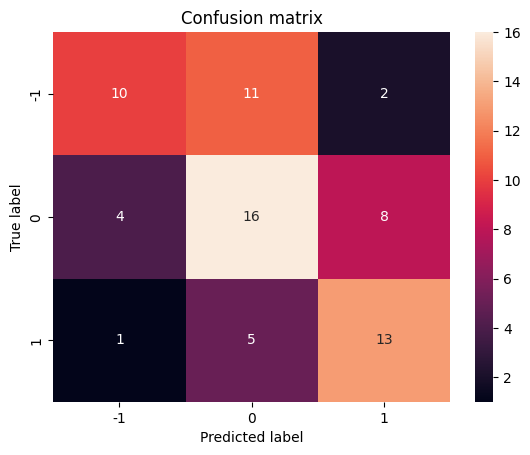

Финальная метрика: 0.5596
Лучшая стратегия: mean_weighted_position


'\n# Вариант 2: Максимально безопасная версия\ntry:\n    safe_metric, safe_strategy = run_safe_sentence_transformer(X, y, calc_metrics)\n    if isinstance(safe_metric, (int, float)):\n        print(f"Безопасная метрика: {safe_metric:.4f}")\n    else:\n        print(f"Безопасная метрика: {safe_metric}")\n    print(f"Стратегия: {safe_strategy}")\nexcept Exception as e:\n    print(f"Ошибка в безопасной версии: {e}")\n\n# Вариант 3: Пошаговый запуск для отладки\ntry:\n    st_model = ImprovedSentenceTransformer()\n    embeddings = st_model.extract_embeddings(X.release.tolist()[:10])  # Тестируем на 10 примерах\n    print(f"Тест успешен, размер: {embeddings.shape}")\nexcept Exception as e:\n    print(f"Ошибка в извлечении эмбеддингов: {e}")\n'

In [ ]:

try:
    final_metric, best_strategy = run_improved_sentence_transformer(X, y, calc_metrics)
    if isinstance(final_metric, (int, float)):
        print(f"Финальная метрика: {final_metric:.4f}")
    else:
        print(f"Финальная метрика: {final_metric}")
    print(f"Лучшая стратегия: {best_strategy}")
except Exception as e:
    print(f"Ошибка: {e}")


Основные улучшения в best_sentence_transformer_chunk:
1. Множественные стратегии pooling
Базовая модель: только mean pooling

лучшенная модель: 4 стратегии

- Mean pooling (стандартный)
- Max pooling (выделение наиболее важных признаков)
- Weighted pooling (больший вес для начала текста)
- Attention pooling (механизм внимания)


2. Продвинутые методы агрегации чанков
Базовая модель: простое среднее по чанкам
Улучшенная модель: 5 стратегий агрегации

- Mean aggregation
- Max aggregation
- Weighted position (больший вес начальным чанкам)
- Attention weighted (веса на основе важности)
- Top-k concatenation (отбор наиболее важных чанков)

3. Иерархическое разбиение текста
4. Автоматический подбор лучшей стратегии
Улучшенная модель тестирует разные комбинации стратегий и выбирает лучшую:
Результаты метрик:
- F1 Score:

-- sentence_transformer_chunk - 0.502

-- best_sentence_transformer_chunk - 0.692
- Accuracy:

-- sentence_transformer_chunk - 0.514

-- best_sentence_transformer_chunk - 0.560

Лучшая стратегия: mean + weighted_position